After the data EDA of the Jupyter Notebook called 'Premodling EDA.'

<a id="0"></a> <br>
 # Table of Contents  
1. [Introduction](#1)
    1. [Loading Packages](#2) 
    1. [Loading Dataset](#3) 
    1. [Defining the tokenizer](#4) 
1. [Data Preprossing](#5) 
    1. [CountVectorizer](#6) 
1. [Modeling](#7)     
    1. [Naive Bayes](#8) 
        1. [Naive Bayes Evaluation](#9) 
    1. [Logistic Regression](#10) 
        1. [Logistic Regression Hyperparameter Optimization](#11)
        1. [Logistic Regression Evaluation](#12)
        1. [Model Coefficients](#16)
    1. [Decision Tree](#13) 
        1. [Decision Tree Hyperparameter Optimization](#14)
        1. [Decision Tree Evaluation](#15) 
1. [Conclusion](#17)  

<a id="1"></a> 
# 1. Introduction

For this notebook we will be using CountVectorization on 3 different models, Logistic Regression, Decision Tree and Naive Bayes.

<a id="2"></a> 
### 1a. Loading Packages

In [216]:
from collections import Counter
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from textblob import Word
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

# Ignore futurewarnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /Users/Amol/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Amol/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Amol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<a id="3"></a> 
### 1a. Loading Dataset

Loading the dataset from the EDA notebook

In [217]:
dataset = pd.read_csv('Capstone.csv')

In [218]:
# Sanity Check
dataset.head()

,description,gluten_free?
0,honeysuckle white fresh 97% ground white turke...,1
1,honeysuckle white 85% fresh ground turkey 1.25...,1
2,honeysuckle white fresh 99% fat free turkey br...,1
3,"turkey wings, 3 - 4 lbs",1
4,honeysuckle white fresh turkey split breast,1


In [219]:
dataset['gluten_free?'].value_counts()

1    947613
0    334510
Name: gluten_free?, dtype: int64

<a id="4"></a> 
### 1c. Defining the tokenizer

<b>my_tokenizer<b> function will:

1. Replace hyphens with spaces and converts the sentence to lowercase.
2. Tokenizes the sentence into words based on various delimiters like commas, parentheses, and brackets.
3. Processes each word:
    - Removes leading and trailing whitespace.
    - Filters out empty strings, words containing periods, and the word   "ingredient."
    - Tries to convert words to their singular form using WordNet's morphy function. If a singular form is found, it's used; otherwise, the original word is kept.
4. Returns a list of processed words.

In [220]:
def my_tokenizer(sentence):
    # Remove hyphens and set to lowercase
    sentence = sentence.replace('-', ' ').lower()

    # Tokenize sentence into words
    listofwords = re.split(r'[,\(\)\[\]]', sentence)
    listofprocessed_words = []

    # Remove empty strings and leading/trailing whitespace
    for word in listofwords:
        word = word.strip()
        if word != '' and '.' not in word and 'ingredient' not in word:
            singular_word = wordnet.morphy(word)
            if singular_word:
                listofprocessed_words.append(singular_word)
            else:
                listofprocessed_words.append(word)

    return listofprocessed_words

In [221]:
# Sanity Check
input_ingredient_list = "GLUTEN FREE FLOUR (TAPIOCA-STARCH, WHITE RICE FLOUR, SORGHUM FLOUR, CORN STARCH), PALM OIL, WATER, EGGS, SUGAR, SALT, XANTHAN GUM, CHERRY FILLING (CHERRIES, WATER, SUGAR, CORN SYRUP, MODIFIED FOOD STARCH, VEGETABLE GUM, CITRIC ACID, VEGETABLE EXTRACT)."
preprocessed_tokens = my_tokenizer(input_ingredient_list)
print(preprocessed_tokens) 

['gluten free flour', 'tapioca starch', 'white rice flour', 'sorghum flour', 'corn starch', 'palm oil', 'water', 'eggs', 'sugar', 'salt', 'xanthan gum', 'cherry filling', 'cherry', 'water', 'sugar', 'corn syrup', 'modified food starch', 'vegetable gum', 'citric acid', 'vegetable extract']


<div class="alert alert-block alert-success">
<b>Sanity Check:</b> From the sanity check we can see the function works as the hyphens are replaced with spaces, converts words to their singular form, removes leading and trailing whitespace, tokenizes the sentence into words based on various delimiters like commas, parentheses, and brackets, and returns a list of processed words.
</div>

----

<a id="5"></a> 
# Modeling

<b>my_tokenizer<b> function will:

1. Replace hyphens with spaces and converts the sentence to lowercase.
2. Tokenizes the sentence into words based on various delimiters like commas, parentheses, and brackets.
3. Processes each word:
    - Removes leading and trailing whitespace.
    - Filters out empty strings, words containing periods, and the word   "ingredient."
    - Tries to convert words to their singular form using WordNet's morphy function. If a singular form is found, it's used; otherwise, the original word is kept.
4. Returns a list of processed words.

-------

<a id="6"></a> 
### Creating the base for the models using CountVectorizer

#### Lets start with spliting the data:

X = dataset['description']: This line selects the 'description' column from the dataset dataset and assigns it to the variable X. This will be the feature data, which consists of product description.

y = dataset['gluten_free?']: This line selects the 'gluten_free?' column from the dataset dataset and assigns it to the variable y. This will be the target data, which represents the gluten-free status corresponding to each ingredient list in X.

In [222]:
# Split the data into features (ingredient lists) and labels (gluten-free status)
X = dataset['description']
y = dataset['gluten_free?']

In [223]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X, y, test_size = 0.2,
                     random_state=1)

Now, `X_remainder` and `y_remainder` contain the other 80%. Of remaining data, we take a 70% training set and 30% validation set.

1. X_remainder: This variable contains the training features (product descriptions) that make up 80% of the dataset.
2. y_remainder: This variable contains the corresponding training labels (gluten-free status) for the training features in X_remainder.
3. X_test: This variable contains the test features (product descriptions) that make up 20% of the dataset.
4. y_test: This variable contains the corresponding test labels (gluten-free status) for the test features in X_test.

In [224]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, test_size = 0.3,
                     random_state=1)

1. X_train and y_train: These variables contain the training features (product descriptions) and labels (gluten-free status) for model training.

2. X_validation and y_validation: These variables contain the validation features and labels, which will be used to tune model hyperparameters and monitor model performance during training.

Let's see the size of the splits

In [225]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (256425,)
Shape of validation set: (307710,)
Shape of train set: (717988,)


### CountVectorizer

In [226]:
# Vectorize the description lists using CountVectorizer

bagofwords = CountVectorizer(min_df=5,
                             max_features=1000,
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)
X_validation_transformed = bagofwords.transform(X_validation)
X_remainder_transformed = bagofwords.transform(X_remainder)

X_train_transformed.shape

(717988, 1000)

##### The use of  CountVectorizer:

1. CountVectorizer Initialization: CountVectorizer is initialized with certain parameters:
    a.min_df=5: Words that appear in fewer than 5 product descriptions will be excluded from the vocabulary.
    b.max_features=1000: This limits the vocabulary to the top 1000 most frequent words.
    c.tokenizer=my_tokenizer: my_tokenizer to tokenize the text data.

2. Fitting the Vectorizer:
    a.bagofwords.fit(X_train): The CountVectorizer is fit on the training data (X_train), which builds the product descriptions based on the words in X_train.

3. Transforming Data:
    a.X_train_transformed: This contains the vectorized representation of the training data.
    b.X_test_transformed: This contains the vectorized representation of the test data.
    c.X_validation_transformed: This contains the vectorized representation of the validation data.
    d.X_remainder_transformed: This contains the vectorized representation of the remainder data.

##### Let's look at the top 20 occuring words

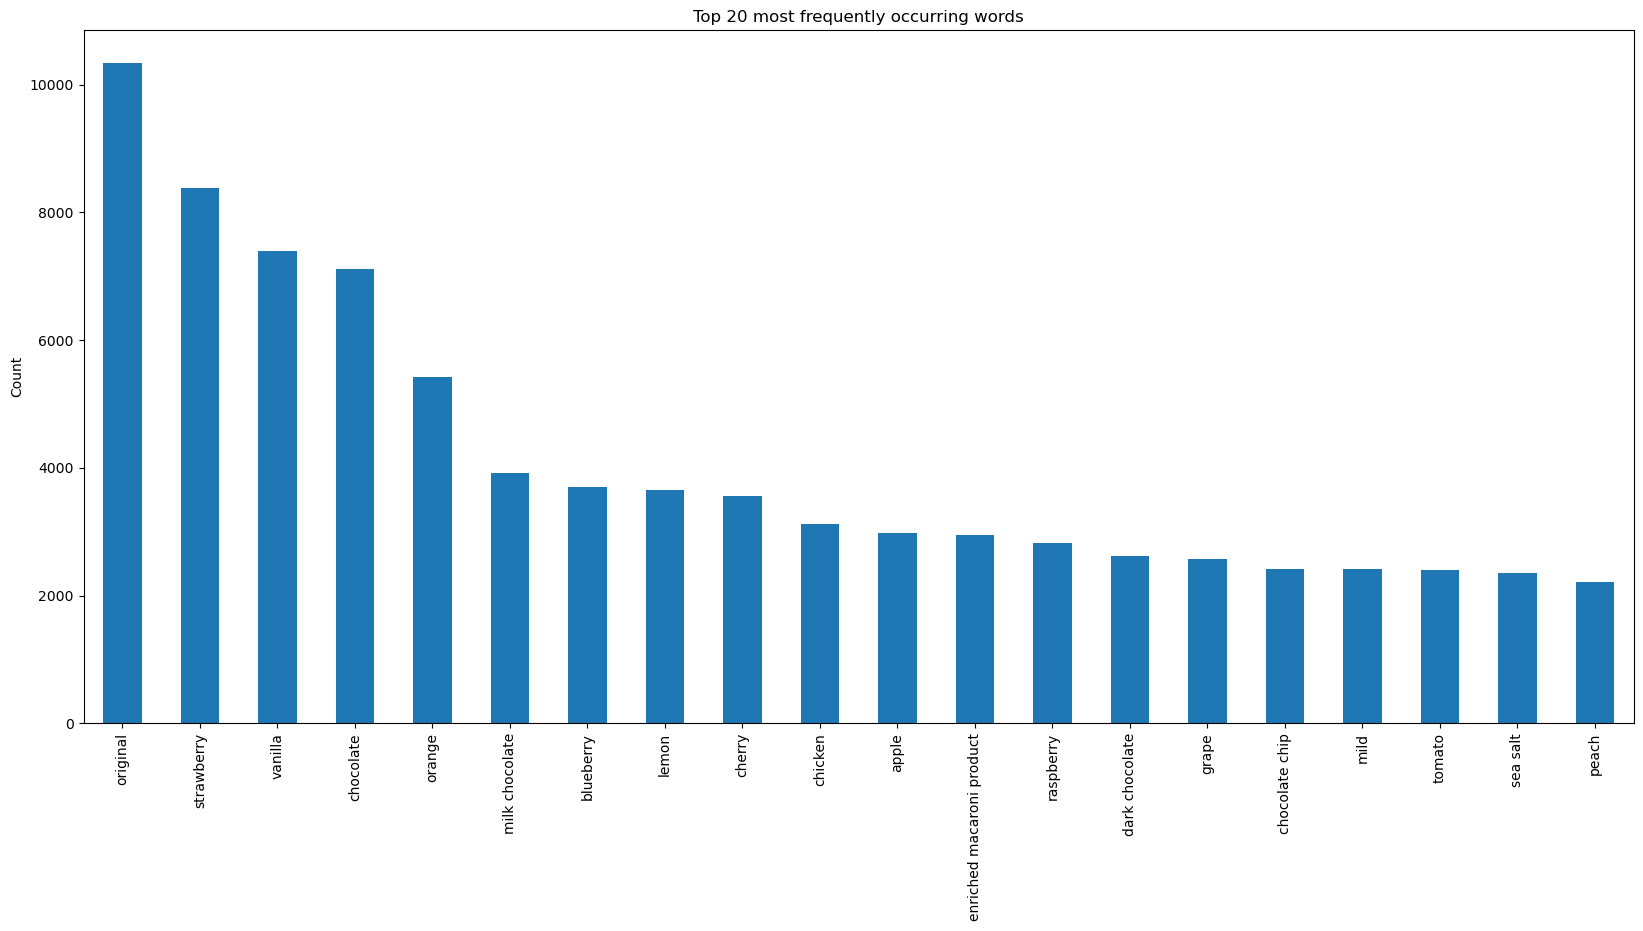

In [227]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(20, 9), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.show()

The top word "original" is very common in the vocabulary and then we can see a sharp decrease in the count of the other words.

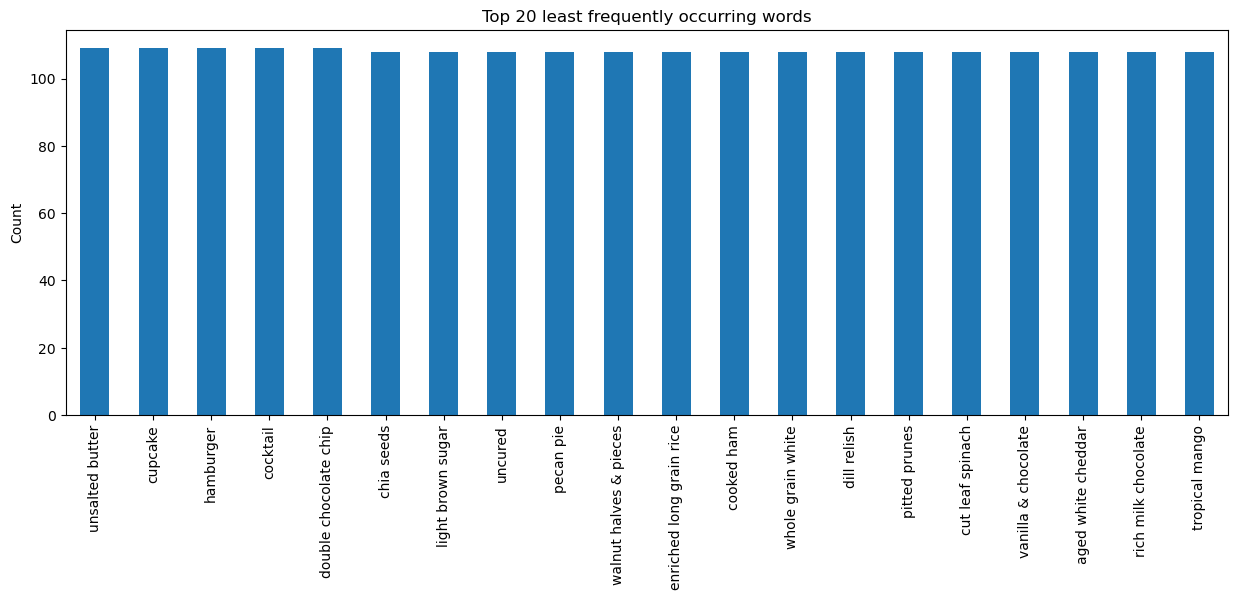

In [228]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.tail(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 least frequently occurring words")
plt.ylabel("Count")
plt.show()

The 20 least occuring words are distributed evenly.

----

<a id="7"></a> 
# Modeling

-----

<a id="8"></a> 
### Naive Bayes

----

Naive Bayes classifer is used for text classification tasks due to efficiency, and suitability for text data. They serve as a good baseline model and can handle both binary and multiclass classification, which is perfect for the purposes of this project

In [229]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_transformed)

1. model = MultinomialNB(): Initialize a Multinomial Naive Bayes classifier (MultinomialNB). 
2. model.fit(X_train_transformed, y_train): Train the Naive Bayes classifier using the vectorized training data 
3. 
    y_pred = model.predict(X_test_transformed): After training the classifier, you use it to make predictions on the test data 

<a id="9"></a> 
##### Naive Bayes Evaluation

Accuracy: 0.7609515452861461
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.17      0.27     66764
           1       0.77      0.97      0.86    189661

    accuracy                           0.76    256425
   macro avg       0.71      0.57      0.57    256425
weighted avg       0.74      0.76      0.71    256425



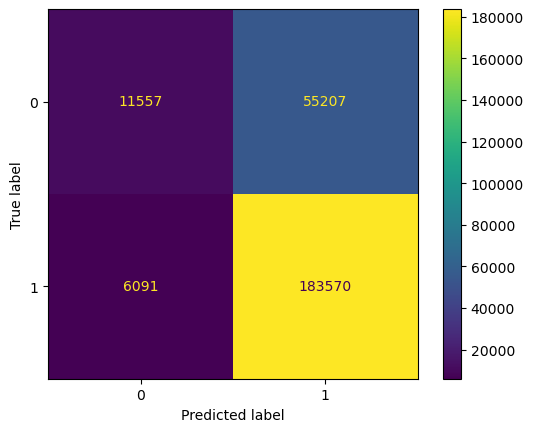

In [230]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_transformed, y_test)

<div class="alert alert-block alert-success">
<b>Accuracy:</b> The accuracy of the model is approximately 74.10%.

<b>Precision:</b> Precision is the proportion of true positive predictions (correctly predicted gluten-free products) out of all positive predictions (true positives + false positives). For class 0, 72% of the instances predicted as class 0 were actually class 0, and for class 1, 74% of the instances predicted as class 1 were actually class 1.
    
<b>Recall:</b> Recall is the proportion of true positive predictions out of all actual positives (true positives + false negatives). The model performed badly for class 0 recall, correctly identifying only about 1% of the actual class 0 instances, while it performed very well for class 1 recall, correctly identifying all (100%) of the actual class 1 instances
    
<b>Support:</b> Support represents the number of examples in each class in the test dataset. There are 66,764 examples of class 0 and 189,661 examples of class 1. So there is an impalance of the two classes.
</div>

<div class="alert alert-block alert-success">
<b>Summary:</b> The model achieved an accuracy of approximately 74.10%. The model has a high precision and recall for gluten-free products, it has a lower precision and recall for not gluten-free products. This suggests that the model performs well at identifying gluten-free products but not with classifying non-gluten-free products.
</div>

----

<a id="10"></a> 
### Logistic Regression

----

Logitic Regression classifer is used for binary classification tasks due to efficiency, and scalability.

In [231]:
# Fitting a model
logreg = LogisticRegression()
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.7603121500637894
Test score: 0.7609476455103832


1. logreg = LogisticRegression(): Initialize a Logistic Regression classifier (LogisticRegression). 
2. logreg.fit(X_train_transformed, y_train): The Logistic Regression model is trained using the vectorized training data.

3. Train and Test scores can be increased using Hyperparameter Optimization

<a id="11"></a> 
##### Logistic Regression Hyperparameter Optimization

In [232]:
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logreg_HP = LogisticRegression(C = c,random_state=1)
    logreg_HP.fit(X_train_transformed,y_train)
    
    # train on traning set
    train_scores.append(logreg_HP.score(X_train_transformed,y_train))
    # score on validation set
    validation_scores.append(logreg_HP.score(X_validation_transformed,y_validation))
    

This code conducts hyperparameter tuning for a Logistic Regression model by going through a range of C values. For each C value, it trains a Logistic Regression model on the training data and records the accuracy scores on both the training and validation datasets. This process helps identify the best C value for the model by evaluating its performance.

Now lets plot all the Train and Validation Scores based on the range of C values.

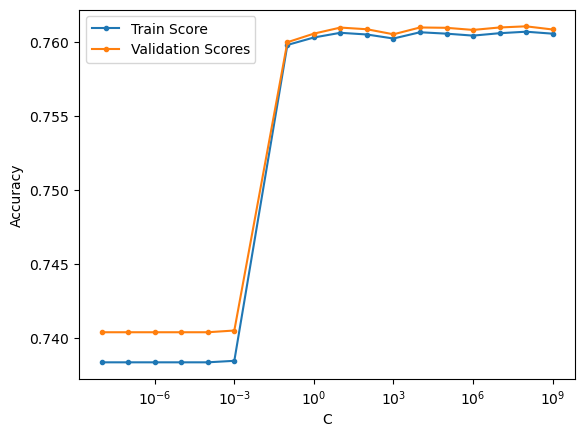

In [233]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

From this plot we can see C=10 is the model with the best fit, lets create a new model based on the same.

In [234]:
final_LR_model = LogisticRegression(C=10, random_state=1)

# Use the remainder data to retrain the model

final_LR_model.fit(X_remainder_transformed,y_remainder)
final_LR_model.score(X_test_transformed,y_test)

0.761427317929219

From this we can see the accuracy of the Logistic Regression model has increased by 0.01.

<a id="12"></a> 
##### Logistic Regression Evaluation

Accuracy: 0.761427317929219
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.15      0.25     66764
           1       0.77      0.98      0.86    189661

    accuracy                           0.76    256425
   macro avg       0.73      0.56      0.55    256425
weighted avg       0.75      0.76      0.70    256425



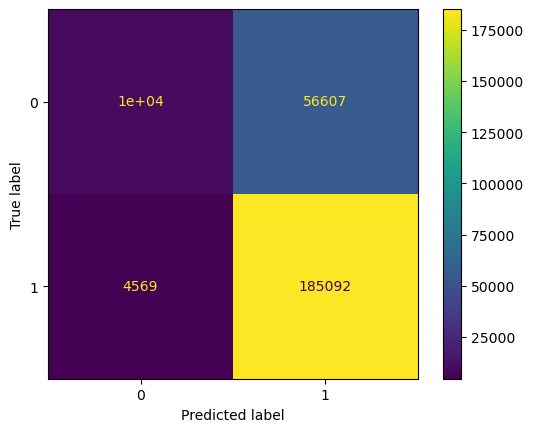

In [235]:
# Make predictions on the test set
y_pred = final_LR_model.predict(X_test_transformed)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(final_LR_model, X_test_transformed, y_test)


<div class="alert alert-block alert-success">
<b>Accuracy:</b> The accuracy of the model is approximately 76.10%.

<b>Precision:</b> Precision for class 1 (gluten-free products) is 0.77, indicating that when the model predicts a product as gluten-free, it is correct 77% of the time. As for class 0 it is 0.69, indicating that when the model predicts a product as non-gluten-free, it is correct 69% of the time.
    
<b>Recall:</b> Recall for class 1 is 0.98, indicating that the model captures 98% of the actual gluten-free products. As for class 0 it is 0.15, indicating that the model captures only 15% of the actual non-gluten-free products.
    
<b>Support:</b> Support represents the number of examples in each class in the test dataset. There are 66,764 examples of class 0 and 189,661 examples of class 1. So there is an impalance of the two classes.
</div>

<div class="alert alert-block alert-success">
<b>Summary:</b> The Logistic Regression model has higher precision and recall for not gluten-free compared to the Naive Bayes model, indicating better performance in identifying non-gluten-free products.
The Naive Bayes model has slightly higher macro and weighted average recall, indicating better recall on average across both classes.
    
Overall, the Logistic Regression model shows a slight advantage in terms of precision and overall weighted average F1-Score, espically for not gluten-free. 
</div>

<a id="16"></a> 
##### Logistic Regression coefficients

Let's look at the coefficients of our model:

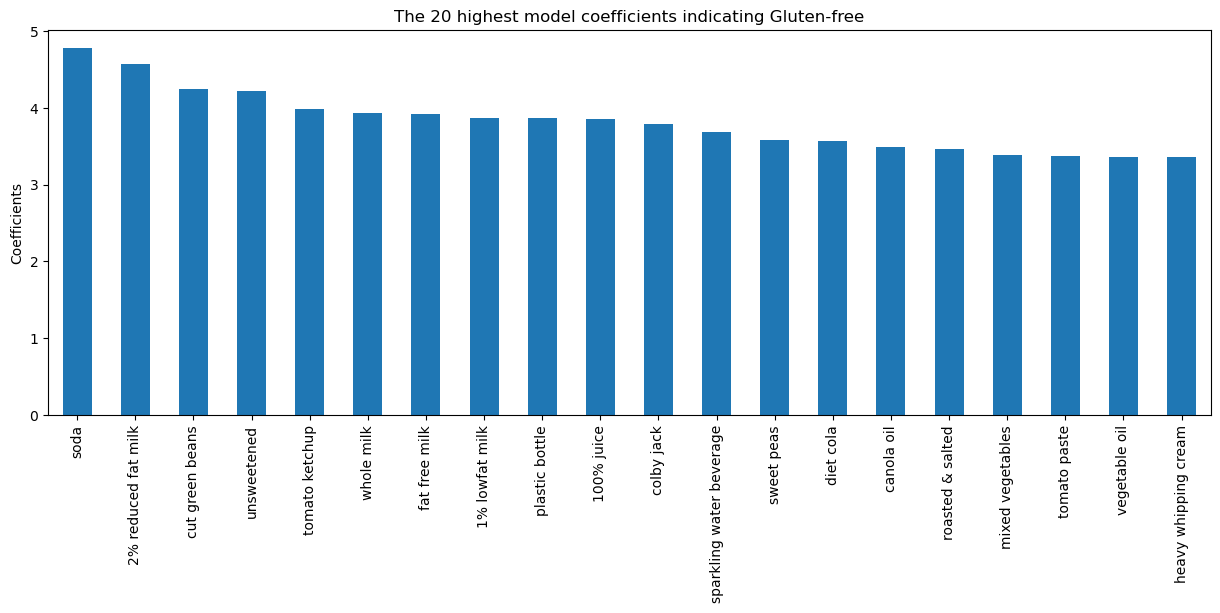

In [236]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating Gluten-free")
plt.ylabel("Coefficients")
plt.show()

In [237]:
# looking at the raw data
word_counts.head(20)

,coefficients
soda,4.775337
2% reduced fat milk,4.565656
cut green beans,4.240127
unsweetened,4.219187
tomato ketchup,3.981708
whole milk,3.927323
fat free milk,3.914299
1% lowfat milk,3.866349
plastic bottle,3.862637
100% juice,3.857883


Lets look at the coefficients indicating not gluten-free

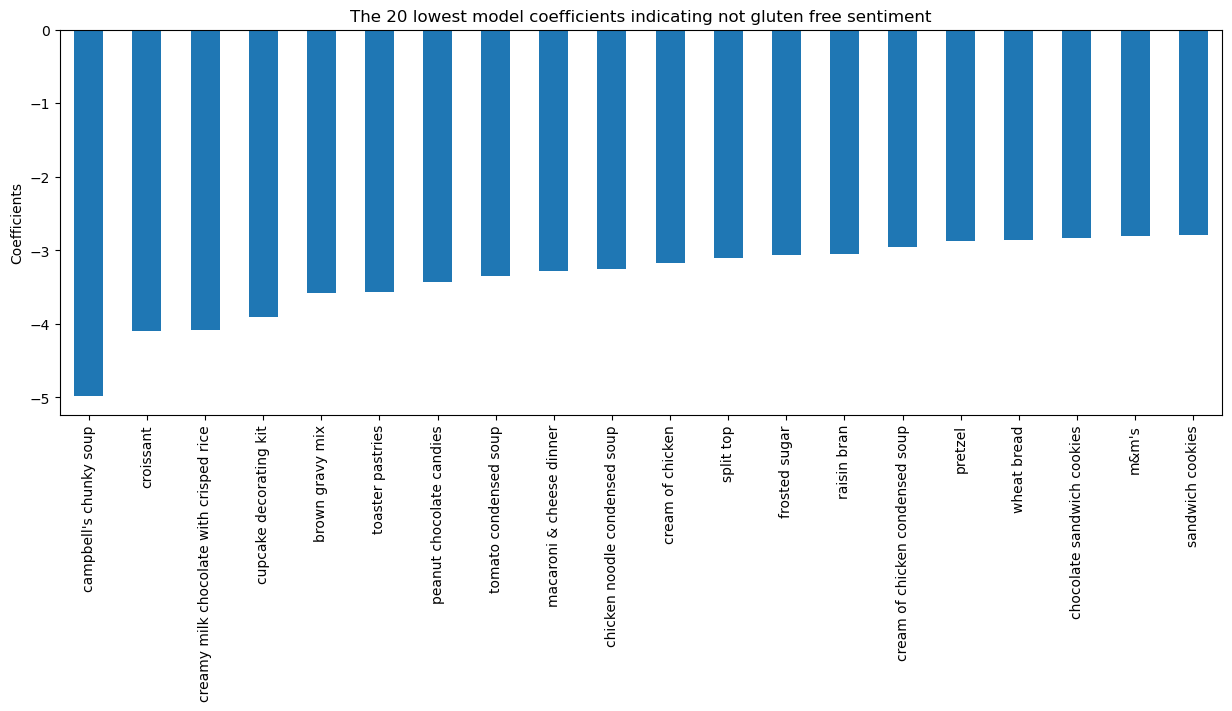

In [238]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating not gluten free sentiment")
plt.ylabel("Coefficients")
plt.show()

In [239]:
# looking at the raw data
word_counts.tail(20).sort_values('coefficients', ascending=True)

,coefficients
campbell's chunky soup,-4.984297
croissant,-4.093432
creamy milk chocolate with crisped rice,-4.087056
cupcake decorating kit,-3.905638
brown gravy mix,-3.580046
toaster pastries,-3.561867
peanut chocolate candies,-3.430997
tomato condensed soup,-3.346140
macaroni & cheese dinner,-3.280695
chicken noodle condensed soup,-3.259299


----

<a id="13"></a> 
### Decision Tree Classifier

-----

In [240]:
# Instantiate model
dt = DecisionTreeClassifier()
# Fit models
dt.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

In [241]:
# Make predictions on the test set
y_pred = dt.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')

Accuracy: 0.7657872672321342


Lets see if we can increase the accuracy of the model.

<a id="14"></a> 
##### Decision Tree Hyperparameter Optimization

In [242]:
# Max Depth
dt.max_depth

In [243]:
# DT
depths = list(range(1, 190, 10))
train_scores = []
validation_scores = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train_transformed, y_train)
        
    #Evaluate
    train_scores.append(dt.score(X_train_transformed, y_train))
    validation_scores.append(dt.score(X_validation_transformed, y_validation))

This code performs a hyperparameter search by training multiple Decision Tree models with varying maximum depths. It records the training and validation set accuracy scores for each depth setting. This process helps identify the optimal maximum depth.

Now lets plot all the Train and Validation Scores based on the max_depth.

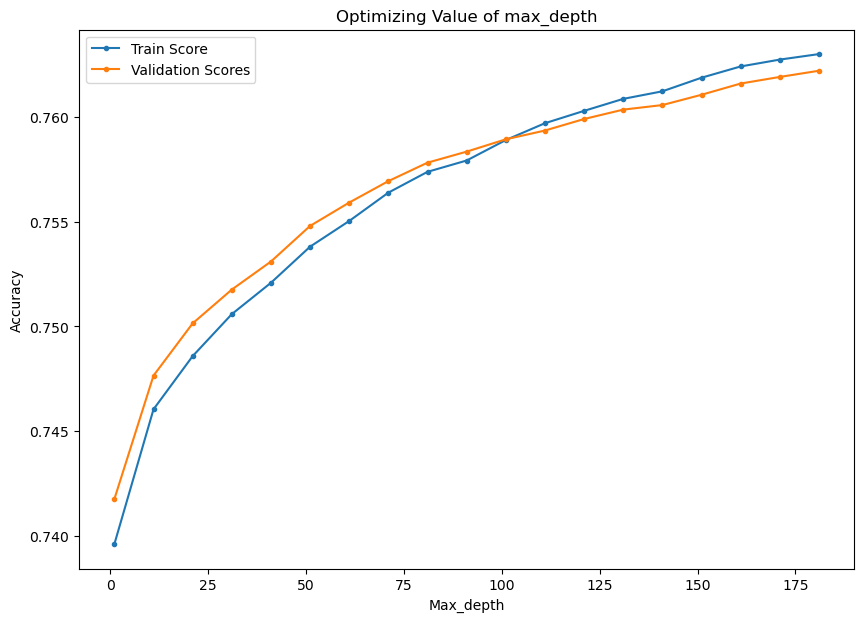

In [244]:
plt.figure(figsize=(10,7))
plt.plot(depths, train_scores,label="Train Score",marker='.')
plt.plot(depths, validation_scores,label="Validation Scores",marker='.')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.title("Optimizing Value of max_depth")
plt.legend()
plt.show();

Lets take a closer look at the max_depth ranging from 80-110

In [245]:
# DT
depths = list(range(80, 200, 10))
train_scores = []
validation_scores = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train_transformed, y_train)
        
    #Evaluate
    train_scores.append(dt.score(X_train_transformed, y_train))
    validation_scores.append(dt.score(X_validation_transformed, y_validation))

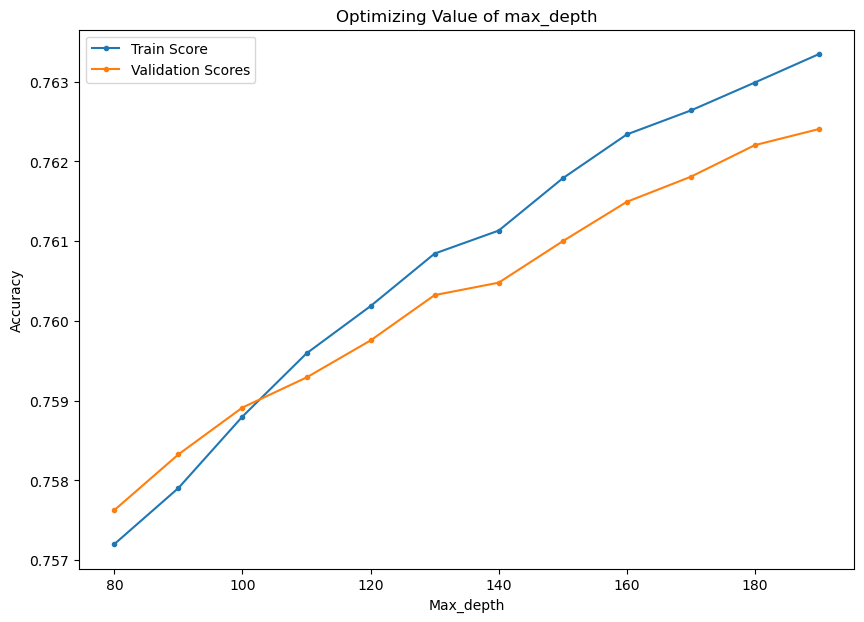

In [246]:
plt.figure(figsize=(10,7))
plt.plot(depths, train_scores,label="Train Score",marker='.')
plt.plot(depths, validation_scores,label="Validation Scores",marker='.')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.title("Optimizing Value of max_depth")
plt.legend()
plt.show();

From this graph we can see the best max_depth is 190

In [247]:
final_DT_model = DecisionTreeClassifier(max_depth=190)

# Use the remainder data to retrain the model

final_DT_model.fit(X_remainder_transformed,y_remainder)
final_DT_model.score(X_test_transformed,y_test)

0.7628897338403042

The accuracy of the model has not increased by changing the max_depth

<a id="15"></a> 
##### Decision Tree Evaluation

Accuracy: 0.7628897338403042
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.15      0.24     66764
           1       0.77      0.98      0.86    189661

    accuracy                           0.76    256425
   macro avg       0.74      0.56      0.55    256425
weighted avg       0.75      0.76      0.70    256425



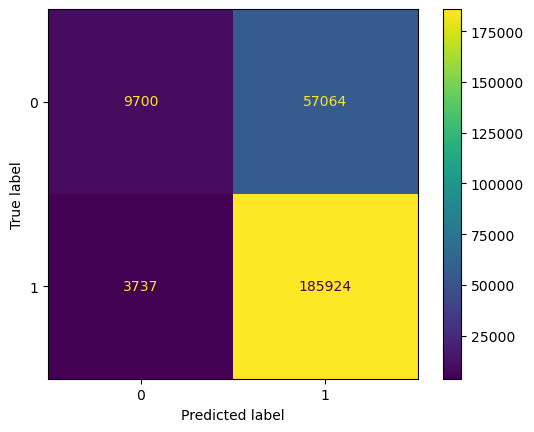

In [248]:
# Make predictions on the test set
y_pred = final_DT_model.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(final_DT_model, X_test_transformed, y_test)

<div class="alert alert-block alert-success">
<b>Accuracy:</b> The accuracy of the model is approximately 76.2%.

<b>Precision:</b> Precision for class 0 (non-gluten-free products) is 0.72, indicating that when the model predicts a product as non-gluten-free, it is correct 72% of the time. Precision for class 1 (gluten-free products) is 0.77, indicating that when the model predicts a product as gluten-free, it is correct 77% of the time.
    
<b>Recall:</b>  Recall for class 0 is 0.15, indicating that the model captures only 15% of the actual non-gluten-free products. Recall for class 1 is 0.98, indicating that the model captures 98% of the actual gluten-free products.
    
<b>Support:</b> Support represents the number of examples in each class in the test dataset. There are 66,764 examples of class 0 and 189,661 examples of class 1. So there is an impalance of the two classes.
</div>

<div class="alert alert-block alert-success">
<b>Summary:</b> The Logistic Regression model has higher precision and recall for not gluten-free compared to the Naive Bayes model, indicating better performance in identifying non-gluten-free products.
The Naive Bayes model has slightly higher macro and weighted average recall, indicating better recall on average across both classes.
    
Overall, the Logistic Regression model shows a slight advantage in terms of precision and overall weighted average F1-Score, espically for not gluten-free. 
</div>

-----

<a id="17"></a> 
# Conclusion

Overall, the Logistic Regression model has a slightly better balance between precision and recall for both classes but the Decision Tree model has the highest accuracy among the three models. The Decision Tree model performs reasonably well but has lower precision and recall for class 0, therefore struggles with identifying non-gluten-free products. The Naive Bayes model performs well but has slightly lower accuracy and precision for class 0 compared to Logistic Regression.  

| Model | Vectorization | Accuracy %|
| --- | --- | --- |
| Naive Bayes | CountVectorization | 0.7416 |
| Logistic Regression | CountVectorization  | 0.7614 |
| Decision Tree | CountVectorization | 0.7628 |

##### Moving on to the next notebook

----